In [1]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl
from IPython.display import display, Math
from wolframclient.language import wlexpr
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Path to the Mathematica kernel
kernelPath = "/Applications/Wolfram.app/Contents/MacOS/WolframKernel"

# Define the path to the Mathematica script
mathematica_script_path = 'MathematicaScripts/LLL.wl'



In [2]:
from wolframclient.language import wlexpr

# Start a Mathematica kernel session
session = WolframLanguageSession(kernel=kernelPath)

# Load the Mathematica script into the session
session.evaluate(f'Get["{mathematica_script_path}"]')

def LogBasis(xin, s1, s2):
    # Create the Mathematica expression as a string
    mathematica_expr = f"Table[Log[{xin} + i]^2, {{i, {{{s1}, {s2}}}}}]"

    # Pass the expression to the Mathematica session using wlexpr
    return session.evaluate(wlexpr(mathematica_expr))

def functlog(xin, s1, s2):
    # Mathematica expression with specific values s1 and s2
    mathematica_expr = f"Total[Table[Log[x + i]^2/i, {{i, {{{s1}, {s2}}}}}]] /. {{x -> {xin}}}"
    
    # Pass the expression to the Mathematica session using wlexpr
    return session.evaluate(wlexpr(mathematica_expr))

I, J = 5, 10

logbasis = LogBasis(wl.x, I, J)
latexLogBasis = session.evaluate(wl.ToString(wl.TeXForm(logbasis)))

display(Math(latexLogBasis))

print("test probe:")

testprobe = [functlog(f"{n}", I, J) for n in (3, 12)]

latexProbe = session.evaluate(wl.ToString(wl.TeXForm(testprobe)))
display(Math(latexProbe))

print("basis eval:")

basiseval = [LogBasis(f"{n}", I, J) for n in (3, 12)]

latexbasis = session.evaluate(wl.ToString(wl.TeXForm(basiseval)))
display(Math(latexbasis))

arrayLLL = session.evaluate(
    wl.Global.ArrayLatRed(basiseval, testprobe, 30)
)

print("performed LLL")

LatexArrayLLL = session.evaluate(wl.ToString(wl.TeXForm(arrayLLL)))

# Print the result
print(f"Array LLL result:")
display(Math(LatexArrayLLL))

#check if equivalent
mapThread = session.evaluate(wl.MapThread(wl.Times, wl.List(arrayLLL, LogBasis(f"{wl.x}", I, J))))
sumMap = session.evaluate(wl.Plus(*mapThread))  # This will unpack and sum the elements
mapLatex = session.evaluate(wl.ToString(wl.TeXForm(sumMap)))

# Print the result
print(f"MapThread:")
display(Math(mapLatex))

print("Are equivalent?")
equiv = session.evaluate(sumMap == functlog(f"{wl.x}", I, J))
print(equiv)

# Terminate the session
session.terminate()

<IPython.core.display.Math object>

test probe:


<IPython.core.display.Math object>

basis eval:


<IPython.core.display.Math object>

performed LLL
Array LLL result:


<IPython.core.display.Math object>

MapThread:


<IPython.core.display.Math object>

Are equivalent?
True


## We want to test what happens as (i - j) varies, as well as how precision varies as $\epsilon \to 0$ points we evaluate i + $\epsilon$, j + $\epsilon$ 

In [95]:
# Start a Mathematica kernel session
session = WolframLanguageSession(kernel=kernelPath)

# Load the Mathematica script into the session
session.evaluate(f'Get["{mathematica_script_path}"]')


def varyDifference(s1, distance, epsilon):
    #function to get minimum number of digits to get result
    equivalent = False
    precision = 1
    s2 = s1 + distance

    def checkLLL(LLLresult):

        mapThread = session.evaluate(wl.MapThread(wl.Times, wl.List(LLLresult, LogBasis(f"{wl.x}", s1, s2))))
        sumMap = session.evaluate(wl.Plus(*mapThread))  # This will unpack and sum the elements
        equiv = session.evaluate(sumMap == functlog(f"{wl.x}", s1, s2))
        return equiv
    

    testprobe = [functlog(f"{n}", s1, s2) for n in (-1*s1 + epsilon, -1*s2 + epsilon)]

    basiseval = [LogBasis(f"{n}", s1, s2) for n in (-1*s1 + epsilon, -1*s2 + epsilon)]

    while not equivalent and precision < 50:

            try:
                arrayLLL = session.evaluate(wl.Quiet(wl.Global.ArrayLatRed(basiseval, testprobe, precision)))
                equivalent = checkLLL(arrayLLL)
                
            except Exception as e:
                pass
                
            precision += 1

    return precision

print(varyDifference(3, 10, 1e-5))

# #vary epsilon
# eps = np.logspace(16,-16, 100)
# minDigitEpsilon = []
# for e in eps:
#     minDigitEpsilon.append(varyDifference(3, 10, e))

#vary distance
dist = np.logspace(0,6, 100, dtype=int)
minDigitDistance = []
for d in dist:
    minDigitDistance.append(varyDifference(3, d, 1e-2))

# Terminate the session
session.terminate()

2


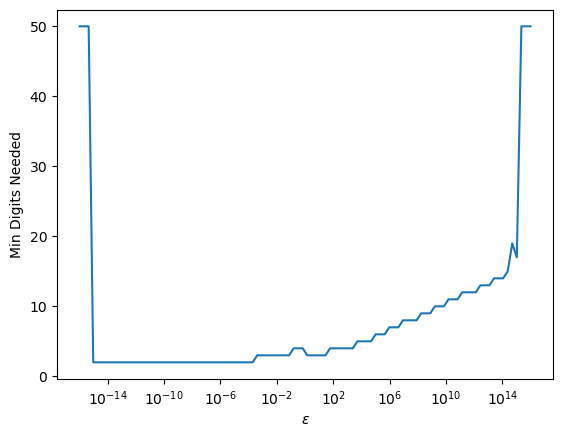

In [41]:
plt.plot(eps, minDigitEpsilon)
plt.xlabel(r'$\epsilon$')
plt.ylabel("Min Digits Needed")
plt.xscale('log')
# plt.ylim(0,5)

And we see the digits of precision scale with

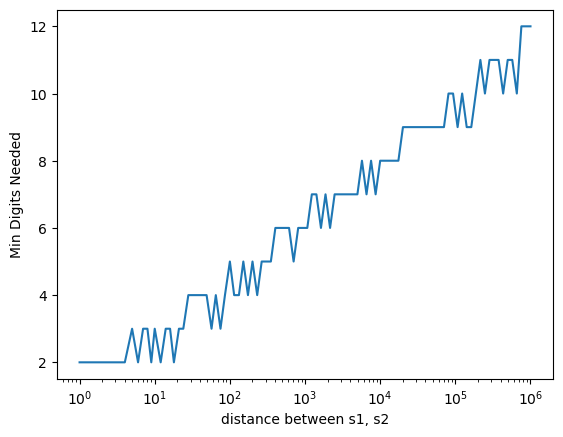

In [96]:
plt.plot(dist, minDigitDistance)
plt.xlabel('distance between s1, s2')
plt.ylabel("Min Digits Needed")
plt.xscale('log')
plt.show()